Connected to Python 3.11.1

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os
from sklearn.model_selection import train_test_split

In [2]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, no_of_patches, hidden_size):
        super(PatchEncoder, self).__init__(name= "patch_encoder")
        self.no_of_patches=no_of_patches
        self.linear_projection= tf.keras.layers.Dense(hidden_size)
        self.positonal_embedding= tf.keras.layers.Embedding(no_of_patches,hidden_size)
    
    def call(self, img):
        patches=tf.image.extract_patches(images=img,
                                 sizes=[1,16,16,1],
                                 strides=[1,16,16,1],
                                 rates=[1,1,1,1],
                                 padding='VALID')
                                 
        patches=tf.reshape(patches,(tf.shape(patches)[0],-1,patches.shape[-1]))
        embedding_input=tf.range(0,self.no_of_patches,1)
        ans=self.linear_projection(patches)+self.positonal_embedding(embedding_input)
        return ans

In [3]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, no_of_heads, hidden_size):
        super(TransformerEncoder, self).__init__(name= "transformer_encoder")
        self.layer_norm= tf.keras.layers.LayerNormalization()
        self.multi_head_attention=tf.keras.layers.MultiHeadAttention(no_of_heads,hidden_size)
        self.denselayer=tf.keras.layers.Dense(hidden_size, activation='gelu')
    
    def call(self, img):
        x_1=self.layer_norm(img)
        x_1=self.multi_head_attention(x_1,x_1)
        x_1=tf.keras.layers.Add()([x_1,img])

        x_2=self.layer_norm(x_1)
        x_2=self.denselayer(x_2)
        ans=self.denselayer(x_2)
        ans=tf.keras.layers.Add()([ans,x_1])

        return ans

In [4]:
class VisT(tf.keras.Model):
    def __init__(self, no_of_heads, hidden_size, no_of_patches, no_of_layers,no_of_dense_units):
        super(VisT,self).__init__(name= 'vision_transformer')
        self.no_of_layers=no_of_layers
        self.patch_encoder=PatchEncoder(no_of_patches,hidden_size)
        self.transformer_encoder=[TransformerEncoder(no_of_heads, hidden_size) for _ in range(no_of_layers)]
        self.densel=tf.keras.layers.Dense(no_of_dense_units, "gelu")
        self.densel2=tf.keras.layers.Dense(64, "gelu")
        self.densel3=tf.keras.layers.Dense(32, "gelu")
        self.denselO=tf.keras.layers.Dense(4, "softmax")
    
    def call(self, data, training=True):
        if isinstance(data, tuple):
            img, _ = data  # Extract only the images from the generator output
        else:
            img = data

        # Ensure the correct shape of the input tensor
        img = tf.image.resize(img, (256, 256))  # Resize the image to match the expected size
        img = tf.reshape(img, (tf.shape(img)[0], 256, 256, 3))  # Explicitly reshape to (batch_size, height, width, channels)

        inp = self.patch_encoder(img)

        for i in range(self.no_of_layers):
            inp = self.transformer_encoder[i](inp)

        inp = tf.keras.layers.Flatten()(inp)
        inp = self.densel(inp)
        inp = self.densel2(inp)
        inp = self.densel3(inp)
        return self.denselO(inp)

In [5]:
# Path of the file.
path = 'E:/semester 6/ModelLeaf/M5/Disease_Photos'
size = [256, 256]
classes = ['Alternaria apple', 'Apple mosaic virus', 'Apple_Powdery_Mildew', 'Apple Apple Scab']

In [6]:
# Loading all images
all_images = []
all_labels = []

for class_index, class_name in enumerate(classes):
    class_path = os.path.join(path, class_name)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        all_images.append(img_path)
        all_labels.append(class_index)

In [7]:
# Splitting into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.5, random_state=12
)

In [8]:
# Augmentation with varying parameters
datagen_training_augmentation = ImageDataGenerator(
    shear_range=0.2,
    horizontal_flip=True,
    rotation_range=60
)

In [9]:
# Applying augmentation to increase the training dataset size to 5x.
augmented_images = []
augmented_labels = []

for i in range(5):  
    for img_path, label in zip(train_images, train_labels):
        rotation_angle = np.random.uniform(-60, 60)  
        img = load_img(img_path, target_size=size)
        img_array = img_to_array(img)
        img_array = datagen_training_augmentation.apply_transform(img_array, {'theta': rotation_angle})
        augmented_images.append(img_array)
        augmented_labels.append(label)
    print("W",i)


W 0
W 1
W 2
W 3
W 4


In [10]:
train_images1 = np.array(augmented_images[0:int(len(augmented_images)*0.35)])
train_labels1 = np.array(augmented_labels[0:int(len(augmented_images)*0.35)])
augmented_images=augmented_images[int(len(augmented_images)*0.35):]
augmented_labels=augmented_labels[int(len(augmented_labels)*0.35):]
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

In [11]:
# Splitting the augmented dataset into training and validation sets
train_images2, valid_images, train_labels2, valid_labels = train_test_split(
    augmented_images, augmented_labels, test_size=0.47, random_state=42
)


In [12]:
del augmented_images
del augmented_labels

In [13]:
valid_images1, valid_images2, valid_labels1, valid_labels2=train_test_split(
    valid_images, valid_labels, test_size=0.5, random_state=42
)

In [42]:
# Initializing VisT model
vit = VisT(2, 256, 256, 2, 64)
vit.compile(optimizer="Adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [44]:
# Training the model
epochs=10
trainig_history=[]
for epoch in range(epochs):
    print("Epoch",epoch+1,"/",epochs,"------->")
    if epoch % 2 == 0:
        # Using the first half of the dataset in even epochs
        data = train_images1
        labels = train_labels1
        vdata = valid_images1
        vlabel = valid_labels1
    else:
        # Using the second half of the dataset in odd epochs
        data = train_images2
        labels = train_labels2
        vdata = valid_images2
        vlabel = valid_labels2

    # Training the model using the selected half of the dataset
    h=vit.fit(data, labels, batch_size=32, epochs=1, validation_data=(vdata, vlabel))
    trainig_history.append(h)
#h=vit.fit(train_images, train_labels, epochs=10, validation_data=(valid_images, valid_labels),batch_size=16)

Epoch 1 / 10 ------->
130/130 [==============================] - 179s 1s/step - loss: 161.2829 - accuracy: 0.8731 - val_loss: 6.2706 - val_accuracy: 0.9509
Epoch 2 / 10 ------->
128/128 [==============================] - 183s 1s/step - loss: 10.6703 - accuracy: 0.9379 - val_loss: 4.4137 - val_accuracy: 0.9559
Epoch 3 / 10 ------->
130/130 [==============================] - 171s 1s/step - loss: 5.5066 - accuracy: 0.9588 - val_loss: 1.7872 - val_accuracy: 0.9746
Epoch 4 / 10 ------->
128/128 [==============================] - 170s 1s/step - loss: 2.3701 - accuracy: 0.9655 - val_loss: 6.3251 - val_accuracy: 0.9454
Epoch 5 / 10 ------->
130/130 [==============================] - 172s 1s/step - loss: 1.4145 - accuracy: 0.9766 - val_loss: 4.6714 - val_accuracy: 0.9459
Epoch 6 / 10 ------->
128/128 [==============================] - 164s 1s/step - loss: 2.5611 - accuracy: 0.9655 - val_loss: 4.1256 - val_accuracy: 0.9515
Epoch 7 / 10 ------->
130/130 [==============================] - 154s 1s/

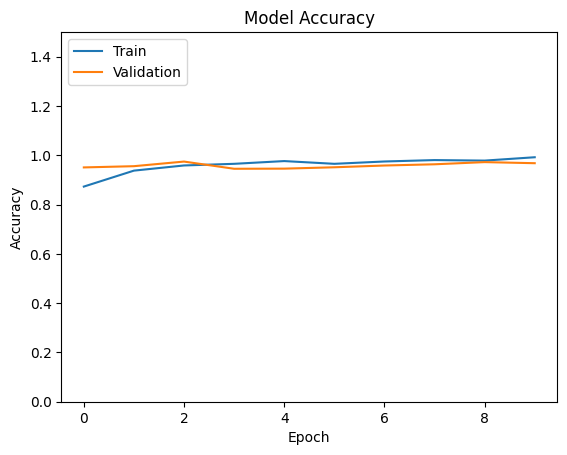

In [45]:
import matplotlib.pyplot as plt
accu=[x.history['accuracy'] for x in trainig_history]
val_accu=[x.history['val_accuracy'] for x in trainig_history]
plt.plot(accu)
plt.plot(val_accu)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper left')
plt.ylim(0,1.5)
plt.show()

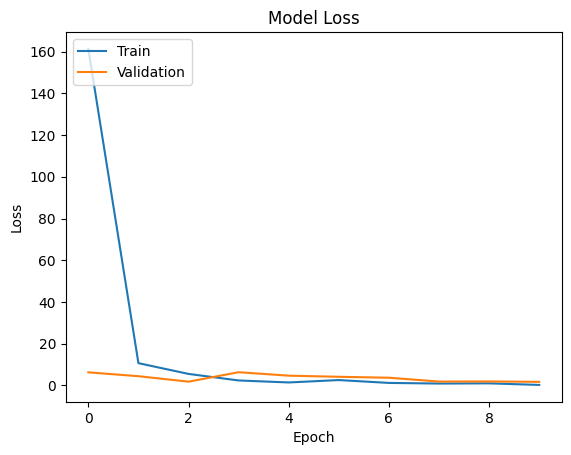

In [46]:
loss=[x.history['loss'] for x in trainig_history]
val_loss=[x.history['val_loss'] for x in trainig_history]
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()

In [47]:
processed_test_images = []
for img_path in test_images:
    img = load_img(img_path, target_size=size)
    img_array = img_to_array(img)
    processed_test_images.append(img_array)

processed_test_images = np.array(processed_test_images)
vit.evaluate(processed_test_images, np.array(test_labels))

75/75 [==============================] - 27s 364ms/step - loss: 2.3711 - accuracy: 0.9629


[2.3711469173431396, 0.962931752204895]

In [48]:
processed_test_images = []
for img_path in test_images:
    img = load_img(img_path, target_size=size)
    img_array = img_to_array(img)
    processed_test_images.append(img_array)

processed_test_images = np.array(processed_test_images)
vit.evaluate(processed_test_images, np.array(test_labels))

75/75 [==============================] - 28s 370ms/step - loss: 2.3711 - accuracy: 0.9629


[2.3711469173431396, 0.962931752204895]

In [49]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.metrics import classification_report

processed_test_images = np.array(processed_test_images)
predictions = np.argmax(vit.predict(processed_test_images), axis=1)

# Display classification report
class_report = classification_report(test_labels, predictions, target_names=classes)
print(class_report)

75/75 [==============================] - 29s 377ms/step
                      precision    recall  f1-score   support

    Alternaria apple       0.77      0.65      0.71       139
  Apple mosaic virus       0.86      0.77      0.81       108
Apple_Powdery_Mildew       0.64      0.84      0.73        95
    Apple Apple Scab       1.00      1.00      1.00      2032

            accuracy                           0.96      2374
           macro avg       0.82      0.82      0.81      2374
        weighted avg       0.96      0.96      0.96      2374



In [50]:
conf_matrix = confusion_matrix(test_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate class-wise accuracy
class_wise_accuracy = {}
for i in range(len(classes)):
    class_accuracy =  np.sum(conf_matrix[i, :]) - conf_matrix[i, i]
    class_accuracy= 1 - (class_accuracy/np.sum(conf_matrix[:, :]))*4
    class_wise_accuracy[classes[i]] = class_accuracy
    print(f"Accuracy for class {classes[i]}: {class_accuracy:.2%}")

# Overall accuracy
overall_accuracy = accuracy_score(test_labels, predictions)
print(f"\nOverall Accuracy: {overall_accuracy:.2%}")

Confusion Matrix:
[[  91    8   37    3]
 [  17   83    8    0]
 [  10    5   80    0]
 [   0    0    0 2032]]
Accuracy for class Alternaria apple: 91.91%
Accuracy for class Apple mosaic virus: 95.79%
Accuracy for class Apple_Powdery_Mildew: 97.47%
Accuracy for class Apple Apple Scab: 100.00%

Overall Accuracy: 96.29%
